# Goal
Thy notebook aims at downloading the model locally and do inference with it.
This should check whether a give machine (e.g. my laptop) is powerful enought for inferencing.

In [1]:
import os

import numpy as np
from typing import List, Tuple, Any

import seaborn as sns
import matplotlib.pyplot as plt
import torch

import project_path

In [2]:
%load_ext autoreload
%autoreload 2

# GPT Neo

## Load the model

In [3]:
MODEL_FOLDER = "../huggingface_models/gpt-neo"
FOLDER_WITH_SAMPLES = "code_snippet_samples"

In [4]:
from transformers import AutoTokenizer, GPTNeoForCausalLM

if os.path.exists(os.path.join(MODEL_FOLDER, "pytorch_model.bin")):
    print("Model loaded locally...")
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_FOLDER)
    model = GPTNeoForCausalLM.from_pretrained(MODEL_FOLDER)
else:
    print("Model downloaded...")
    
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
    
    tokenizer.save_pretrained("../huggingface_models/gpt-neo")
    model.save_pretrained("../huggingface_models/gpt-neo")
print(model)

Model loaded locally...
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Li

## Query the model

In [5]:
prompt = "The first work day was great, "

input_ids = tokenizer(prompt, return_tensors="pt").input_ids
torch.manual_seed(42)

model_output = model.generate(
    input_ids,
    do_sample=True,
    #temperature=0.0000001,
    temperature=0.8,
    output_attentions=True,
    max_length=20, 
    return_dict_in_generate=True
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Explore the Sturcture of the Attention Output

In [6]:
N_PREDICTED_TOKENS_TO_SHOW = 6
print(f"This shows the attention for the first {N_PREDICTED_TOKENS_TO_SHOW} predicted tokens")

for i in range(N_PREDICTED_TOKENS_TO_SHOW): 
    print(f"prediction {i}")
    for j in range(12): # for layers
        print(f" - layer {j} - ", model_output["attentions"][i][j].shape)

This shows the attention for the first 6 predicted tokens
prediction 0
 - layer 0 -  torch.Size([1, 12, 8, 8])
 - layer 1 -  torch.Size([1, 12, 8, 8])
 - layer 2 -  torch.Size([1, 12, 8, 8])
 - layer 3 -  torch.Size([1, 12, 8, 8])
 - layer 4 -  torch.Size([1, 12, 8, 8])
 - layer 5 -  torch.Size([1, 12, 8, 8])
 - layer 6 -  torch.Size([1, 12, 8, 8])
 - layer 7 -  torch.Size([1, 12, 8, 8])
 - layer 8 -  torch.Size([1, 12, 8, 8])
 - layer 9 -  torch.Size([1, 12, 8, 8])
 - layer 10 -  torch.Size([1, 12, 8, 8])
 - layer 11 -  torch.Size([1, 12, 8, 8])
prediction 1
 - layer 0 -  torch.Size([1, 12, 1, 9])
 - layer 1 -  torch.Size([1, 12, 1, 9])
 - layer 2 -  torch.Size([1, 12, 1, 9])
 - layer 3 -  torch.Size([1, 12, 1, 9])
 - layer 4 -  torch.Size([1, 12, 1, 9])
 - layer 5 -  torch.Size([1, 12, 1, 9])
 - layer 6 -  torch.Size([1, 12, 1, 9])
 - layer 7 -  torch.Size([1, 12, 1, 9])
 - layer 8 -  torch.Size([1, 12, 1, 9])
 - layer 9 -  torch.Size([1, 12, 1, 9])
 - layer 10 -  torch.Size([1, 12, 

## Visualize the Attention (as Heatmap)
This shows a condensed version where all the weights are summed over:
- all the predicted tokens
- all the attention heads (12)
- all the layers (12)

<AxesSubplot:>

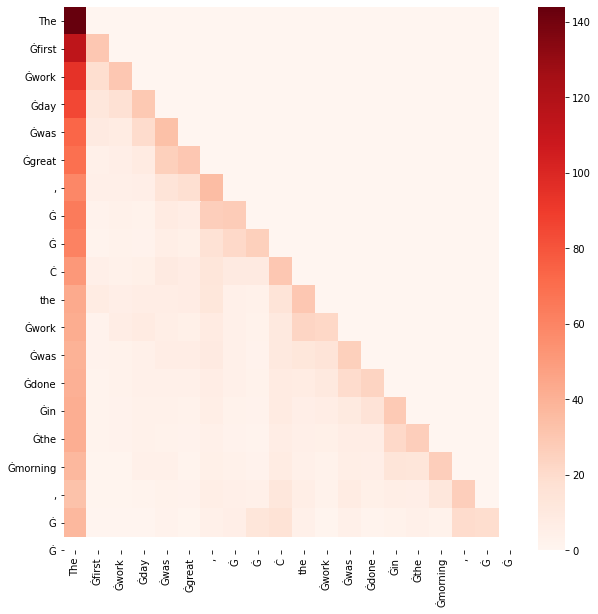

In [7]:
from attwizard.decoder import get_attention_tensor
from attwizard.decoder import merge_attention_prompt_and_new_tokens
from attwizard.decoder import get_attention_matrix
from attwizard.decoder import condense_attention
from attwizard.decoder import heatmap_visualize

att_tensor = get_attention_tensor(
    model_output=model_output
)
condensed_att_tensor = \
    merge_attention_prompt_and_new_tokens(att_tensor)
condensed_att_tensor = \
    condense_attention(condensed_att_tensor, reduce_direction="both")
att_matrix = get_attention_matrix(
    attention_tensor=condensed_att_tensor)
heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=tokenizer.convert_ids_to_tokens(model_output["sequences"][0])
)

## Inspect all layers
We condense all head together with the SUM (default reduce)

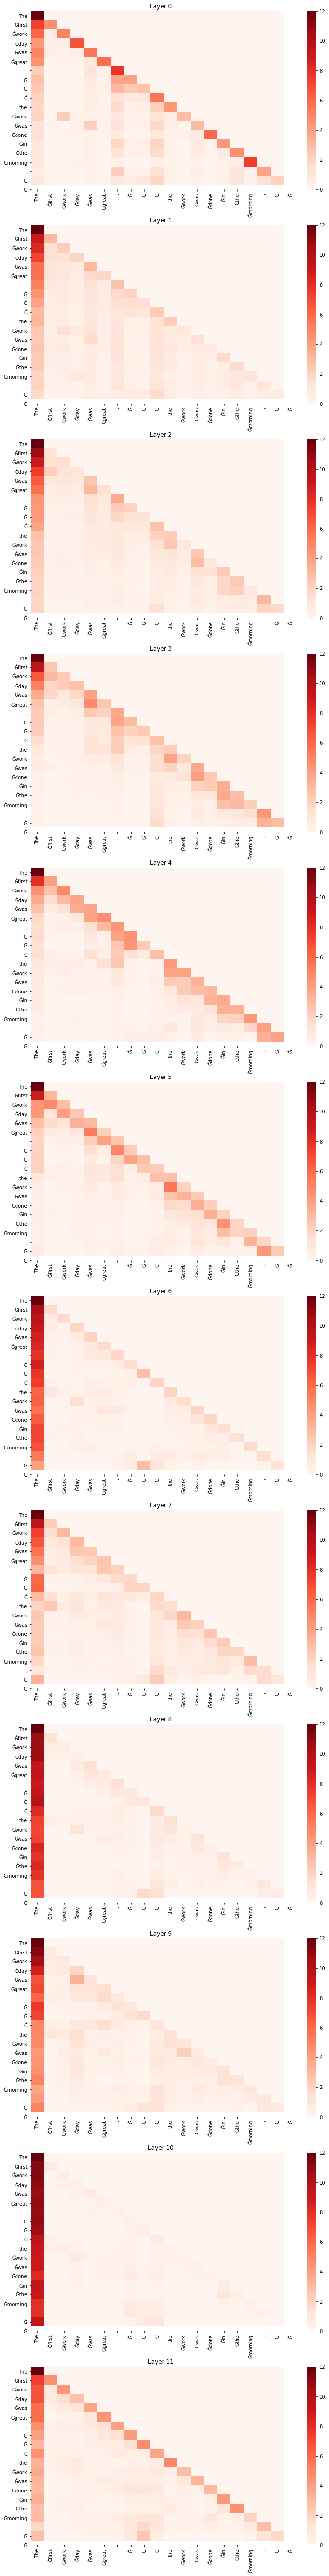

In [8]:
N_LAYERS = 12
fig, axes = plt.subplots(N_LAYERS, 1, figsize=(12, 8*12))

for i in range(N_LAYERS):
    i_ax = axes[i]
    condensed_att_tensor = \
        merge_attention_prompt_and_new_tokens(att_tensor)
    condensed_att_tensor = \
        condense_attention(condensed_att_tensor, reduce_direction="head")
    att_matrix = get_attention_matrix(
        attention_tensor=condensed_att_tensor, layer=i)
    heatmap_visualize(
        attention_matrix=att_matrix,
        token_names=tokenizer.convert_ids_to_tokens(model_output["sequences"][0]),
        ax=i_ax
    )
    i_ax.set_title(f"Layer {i}")
plt.show()